# DEnKF

* Sakov, P. and P. R. Oke, 2008: A determinisitic formulation of the ensemble Kalman filter: an alternative to ensemble sequare root filters. *Tellus*, **60A**, 361–371, [doi:10.1111/j.1600-0870.2007.00299.x](https://doi.org/10.1111/j.1600-0870.2007.00299.x).

* 摂動観測（PO）による標本誤差を回避したEnKF
* 観測に摂動を加えない決定論的な解法だが平方根フィルタとは異なる手法
* アンサンブル摂動の振幅が小さいと仮定して，アンサンブル更新を線型化
* 摂動が大きい場合は解析誤差共分散を過大に評価するため，
* 線型化されたアンサンブル更新は適応インフレーションとして作用する。
* 更新行列は左から行列をかけるので，要素積による状態空間局所化が可能
* 平均の解析とアンサンブル更新は独立しているが，個々のメンバーに対して
同じ観測で解析してアンサンブル平均を取ったものと等価

KFのアンサンブル更新
$$
\begin{aligned}
\mathbf{P}^\mathrm{a} &= (\mathbf{I}-\mathbf{KH})\mathbf{P}^\mathrm{f} & (1)
\end{aligned}
$$

EnKFのアンサンブル更新
$$
\begin{aligned}
\mathbf{P}^\mathrm{a} &= (\mathbf{I}-\mathbf{KH})\mathbf{P}^\mathrm{f}(\mathbf{I}-\mathbf{KH})^\mathrm{T} & (2)
\end{aligned}
$$
式(2)を書き換え2次の項を省略すると
$$
\begin{aligned}
\mathbf{P}^\mathrm{a} &= \mathbf{P}^\mathrm{f} - 2\mathbf{KHP}^\mathrm{f}+\mathbf{KH}\mathbf{P}^\mathrm{f}\mathbf{H}^\mathrm{T}\mathbf{K}^\mathrm{T}\approx(\mathbf{I} - 2\mathbf{KH})\mathbf{P}^\mathrm{f} & (3)
\end{aligned}
$$
となる。摂動を$\mathbf{K}/2$で更新すれば，近似の下で式(1)と一致する。

## DEnKFの計算手順

1. 予報アンサンブル$\mathbf{X}^\mathrm{f}$に対してアンサンブル平均$\mathbf{x}^\mathrm{f}$を式(4)で，アンサンブル摂動$\mathbf{A}^\mathrm{f}$を式(5)で求める。
$$
\begin{aligned}
\mathbf{x}^\mathrm{f} &= \frac{1}{m}\sum_{i=1}^m\mathbf{X}^\mathrm{f} & (4)\\
\mathbf{A}^\mathrm{f}_i &= \mathbf{X}^\mathrm{f}_i - \mathbf{x}^\mathrm{f} & (5)
\end{aligned}
$$
2. 解析$\mathbf{x}^\mathrm{a}$をカルマン解析の式(6)により求める。
$$
\begin{aligned}
\mathbf{x}^\mathrm{a} &= \mathbf{x}^\mathrm{f} + \mathbf{K}(\mathbf{y} - \mathbf{H}\mathbf{x}^\mathrm{f}) & (6)
\end{aligned}
$$
3. 解析摂動$\mathbf{A}^\mathrm{a}$を式(7)により求める。
$$
\begin{aligned}
\mathbf{A}^\mathrm{a} &= \mathbf{A}^\mathrm{f} - \frac{1}{2}\mathbf{KHA}^\mathrm{f} &(7)
\end{aligned}
$$
4. 解析アンサンブル$\mathbf{X}^\mathrm{a}$を式(8)により偏差をずらして計算する。
$$
\begin{aligned}
\mathbf{X}^\mathrm{a} &= \mathbf{A}^\mathrm{a} + [\mathbf{x}^\mathrm{a},\dots,\mathbf{x}^\mathrm{a}] & (8)
\end{aligned}
$$

## DEnKFの解析誤差共分散

式(7)により求めた解析アンサンブルの誤差共分散は
$$
\begin{aligned}
\mathbf{P}^\mathrm{a} &= (\mathbf{I}-\mathbf{KH})\mathbf{P}^\mathrm{f} + \frac{1}{4}\mathbf{KH}\mathbf{P}^\mathrm{f}\mathbf{H}^\mathrm{T}\mathbf{K}^\mathrm{T} & (9)
\end{aligned}
$$
となる。

* $\mathbf{KH}$の2次の項が小さい「弱い」同化では$\mathbf{P}^\mathrm{a}$は精度良く求められる。
* $\mathbf{KH}$の2次の項が無視できない「強い」同化では$\mathbf{P}^\mathrm{a}$を過大評価し，適応インフレーションとして機能する。

In [2]:
import numpy as np
import scipy.linalg as la

In [ ]:
def calc_kalman_gain_mform(pf12, ymat, rmat):
    return pf12 @ ymat.T @ la.inv(ymat @ ymat.T + rmat)

def calc_kalman_gain_nform(pf12, ymat, rinv):
    ic = ymat.T @ rinv @ ymat
    ic[np.diag_indices_from(ic)] += 1.0
    return pf12 @ la.inv(ic) @ ymat.T @ rinv

def update_state(xf, kalman_gain, o_minus_b):
    return xf + kalman_gain @ o_minus_b

def update_anomalies(pf12, kalman_gain, ymat):
    return pf12 - 0.5 * kalman_gain @ ymat

def gen_obs_covariance(rin, nobs, invert=False):
    if type(rin) == float:
        if invert: rin = 1.0 / rin
        rout = np.diag(np.full(nobs, rin))
    elif type(rin) == np.ndarray:
        if rin.dim == 1:
            if invert: rin = 1.0 / rin
            rout = np.diag(rin)
        else:
            if invert: rin = la.inv(rin)
            rout = rin
    return rout

def denkf_analysis(xf, o_minus_b, pf12, ymat, r):
    nstate, nens = pf12.shape
    nobs = o_minus_b.size
    if nobs > nens:
        rmat = gen_obs_covariance(r, nobs)
        kalman_gain = calc_kalman_gain_mform(pf12, ymat, rmat)
    else:
        rinv = gen_obs_covariance(r, nobs, invert=True)
        kalman_gain = calc_kalman_gain_nform(pf12, ymat, rinv)
    xa = update_state(xf, kalman_gain, o_minus_b)
    pa12 = update_anomalies(pf12, kalman_gain, ymat)
    return xa, pa12

# 線型移流モデル

* Evensen, G., 2004: Sampling strategies and square root analysis schemes for the EnKF. *Ocean Dyn.*, **54**, 539–560, [doi:10.1007/s10236-004-0099-2](https://doi.org/10.1007/s10236-004-0099-2).
* 状態の自由度$n=1000$
$$
\begin{aligned}
\mathbf{x}(t) &= [\mathbf{x}_1(t), \dots, \mathbf{x}_n(t)] & t = 1, 2, \dots & (10)
\end{aligned}
$$
* 周期的境界条件で毎時刻右隣に進む（`np.roll(x, 1)`）落ちない完全モデル。 
$$
\begin{aligned}
\mathbf{x}_i(t+1) &= \begin{cases}
\mathbf{x}_{i-1}(t), & i=2,\dots,n \\
\mathbf{x}_n, & i=1
\end{cases} & (11)
\end{aligned}
$$
* 状態を$K=25$の正弦波の重ね合わせで表す。
$$
\begin{aligned}
\mathbf{s}_i &= \sum_{k=0}^{K}a_k\sin\left(\frac{2\pi k}{n}i + \phi_k\right) & (12)
\end{aligned}
$$
  * 振幅0〜1，位相誤差0〜2πの一様乱数。
  * モデルの実次元は$2K+1=51$（波数0は振幅のみ，$k>0$は波数の振幅と位相）
* 分散1に規格化
$$
\begin{aligned}
\mathbf{x}(1) &= \frac{\mathbf{s}}{[(\mathbf{s}-\bar{\mathbf{s}})^\mathrm{T}(\mathbf{s}-\bar{\mathbf{s}})]^\mathrm{1/2}} & (13)
\end{aligned}
$$
* アンサンブル平均を引いて別の標本を加える。
* 真値は第一推定値と別の標本との和
  * 初期平均2乗誤差平方根は1
* 観測は時刻$t=1, 6, 11, \dots$で等間隔$i={125, 375, 625, 875}$において真値から作成し，分散0.01の正規分布の誤差を付加する。

## モデルと観測演算子

In [ ]:
import math


dtobs = 5
nobs = 4
r = 0.01
nens = 55 
nstep = 500

def step(x):
    return np.roll(x, 1)

def gen_state(n, kmax, rng):
    s = np.zeros(n)
    phi0 = math.tau * np.arange(1, n+1) / n
    for k in range(kmax+1):
        ak = rng.random()
        phik = math.tau * rng.random()
        s += ak * np.sin(k * phi0 + phik)
    s /= s.std()
    return s

def gen_ens(nens, n, kmax, rng):
    xmat = np.zeros([n, nens])
    for i in range(nens):
        xmat[:, i] = gen_state(n, kmax, rng)
    xmean = xmat.mean(axis=1)
    return xmat - xmean[:, None]

def gen_obs(xtrue, rng, obs_loc, ystd):
    nobs = obs_loc.size
    y = xtrue[obs_loc] + ystd * rng.standard_normal(nobs)
    return y

def simulate_obs(x, obs_loc):
    return x[obs_loc]

def gen_ymat(pf12, obs_loc):
    n, nens = pf12.shape
    nobs = obs_loc.size
    ymat = np.zeros([nobs, nens])
    for j in range(nens):
        ymat[:, j] = simulate_obs(pf12[:, j], obs_loc)
    return ymat

## 実験設定と初期条件

In [ ]:
n = 1000
kmax = 25
nsave = nstep // dtobs
seed = 514
dtsave = dtobs * 10

obs_int = n // nobs
obs_loc = np.arange(obs_int // 2 - 1, n, obs_int)

rng = np.random.default_rng(seed)

pf12 = gen_ens(nens, n, kmax, rng) / np.sqrt(nens - 1)
xf = gen_state(n, kmax, rng)
xtrue = gen_state(n, kmax, rng) + xf
y = gen_obs(xtrue, rng, obs_loc, np.sqrt(r))

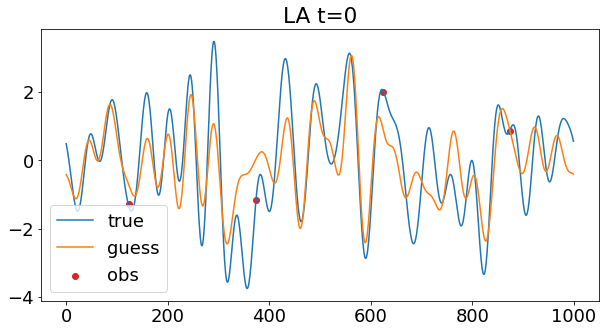

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 18
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(xtrue, label="true")
ax.plot(xf, label="guess")   
ax.scatter(obs_loc, y, c="tab:red", label="obs")
ax.set_title("LA t=0")
ax.legend()
plt.show()

## 同化実験

In [ ]:
sprd= np.zeros([nsave])
l2 = np.zeros([nsave])
i = 0
for t in range(nstep):
    if t % dtobs == 0:
        y = gen_obs(xtrue, rng, obs_loc, np.sqrt(r))
        o_minus_b = y - simulate_obs(xf, obs_loc)
        ymat = gen_ymat(pf12, obs_loc)
        xa, pa12 = denkf_analysis(xf, o_minus_b, pf12, ymat, r)
        xens = xa[:, None] + pa12 * np.sqrt(n - 1)
        l2[i] = (xa - xtrue).std()
        sprd[i] = np.sqrt(np.diag(pa12 @ pa12.T)).mean()
        i += 1
    xtrue = step(xtrue)
    for j in range(nens):
        xens[:, j] = step(xens[:, j])
    xf = xens.mean(axis=1)
    pf12 = (xens - xf[:, None]) / np.sqrt(n - 1)


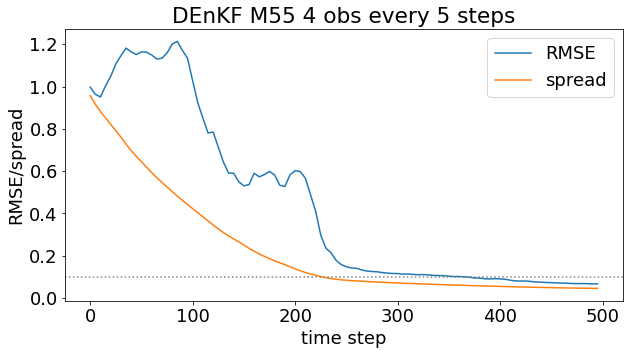

In [ ]:
timestep = np.arange(0, nstep, dtobs)
                           
plt.rcParams["font.size"] = 18  
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(timestep, l2, label="RMSE")
ax.plot(timestep, sprd, label="spread")
ax.axhline(np.sqrt(r), color="gray", linestyle=":")  
ax.legend()
ax.set_xlabel("time step")                 
ax.set_ylabel("RMSE/spread")    
ax.set_title(f"DEnKF M{nens} {nobs} obs every {dtobs} steps")
plt.show()

## 課題

* 観測数や観測頻度，アンサンブル数に対する依存性を調べる。